In [48]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import os
sys.path.insert(0, "../")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from nohomers.notebook.widgets import expand2square, image_labeller_widget, display_df_images
from nohomers.ml.torch_datasets import SimpleVisionExample, SimpleVisionDataset, split_train_valid_test, pil_loader
from nohomers.ml.lightweight_gan_trainer import get_trainer, generate_images
from nohomers.ml.cleaner import make_train_test_datasets, train_cleaner, make_network_input_from_images, load_cleaner, save_cleaner
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
import pandas as pd
import numpy as np
import torch
import torchvision
import pydash as py_
import sklearn.metrics
from tqdm.auto import tqdm
from uuid import uuid4
from PIL import Image
from pathlib import Path
import json
import copy
import shutil
from multiprocessing.pool import ThreadPool
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
base_folder = Path("/mnt/evo/projects/nohomers/cleaners/simpsons_large_cleaned_nobackground_1024_augall03_sle_res64-35")
dataset_folder = base_folder / "images"

In [28]:
## If you want to remove
try:
    shutil.rmtree(base_folder)
except FileNotFoundError:
    pass
dataset_folder.mkdir(parents=True, exist_ok=True)

In [29]:
trainer = get_trainer(
    models_dir="/mnt/evo/projects/metapedia/tmp/stylegan2/models", 
    name="simpsons_large_cleaned_nobackground_1024_augall03_sle_res64",
    load_from=35,
)

loading from version 0.12.4


# Label Results

In [30]:
num_examples = 5000
per_batch = 100
with ThreadPool(32) as pool:
    for batch in tqdm(range(0, num_examples, per_batch)):
        images = generate_images(trainer, per_batch)
        list(
            pool.imap(lambda x: x.image.save(dataset_folder / f"{uuid4()}.png"), images)
        )

In [31]:
images = list(dataset_folder.glob("*.png"))
labels = {}

In [38]:
to_label = py_.sample_size([e for e in images if e not in labels], 100)
image_labeller_widget(to_label, labels, ["N/A", "Good", "Bad"], image_size=(250, 250))

In [39]:
with open(dataset_folder / "labels.json", "w") as f:
    json.dump({
        p.name: label for p, label in labels.items()
    }, f)

In [6]:
with open(dataset_folder / "labels.json", "r") as f:
    labels = {(dataset_folder / p): label for p, label in json.load(f).items()}

# Create Training Dataset Objects

In [7]:
examples = [SimpleVisionExample(path=p, label=(1 if l == "Good" else 0)) for p, l in labels.items()]
percent_positive = np.array([e.label for e in examples]).mean()
print(f"Num labelled={len(examples)}, Percent positive: {100 * percent_positive:.2f}%")

Num labelled=600, Percent positive: 34.33%


In [8]:
train_dataset, test_dataset = make_train_test_datasets(examples)

Dataset sizes train=480, valid=0, test=120


In [ ]:
lr0.001 = 0.072
lr0.01=crap
lr0.0001 = better
lr0.0001 reg =0.0005 best
lr0.0001 reg =0.0005 clip_Norm=1.0

In [ ]:
cleaner = train_cleaner(
    train_dataset, 
    test_dataset, 
    batch_size=50, 
    num_epochs=20,
    device="cuda:0",
    lr=0.0001, 
    l2_reg=0.0005, 
    clip_norm=1.0,
    workers=16,
)

In [51]:
save_cleaner(cleaner, base_folder / "cleaner.pkl")

In [10]:
cleaner = load_cleaner(base_folder / "cleaner.pkl")

# Precision Recall Curve

In [49]:
true = []
preds = []
with torch.no_grad():
    for item, label in test_dataset:
        true.append(label)
        pred = cleaner(item.unsqueeze(0).cuda())
        prob = torch.nn.Softmax(dim=1)(pred).squeeze()
        preds.append(prob[1].item())

In [50]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_true=np.array(true, dtype=np.float), probas_pred=np.array(preds, dtype=np.float))

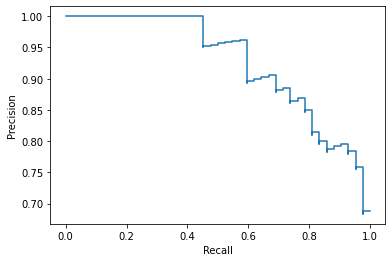

In [51]:
pr_display = sklearn.metrics.PrecisionRecallDisplay(precision=precision, recall=recall).plot()

In [57]:
{t: (p, r) for p, r, t in zip(precision, recall, thresholds)}

{0.35296696424484253: (0.6885245901639344, 1.0),
 0.36201798915863037: (0.6833333333333333, 0.9761904761904762),
 0.3678624629974365: (0.6949152542372882, 0.9761904761904762),
 0.36934220790863037: (0.7068965517241379, 0.9761904761904762),
 0.3738919198513031: (0.7192982456140351, 0.9761904761904762),
 0.3751833140850067: (0.7321428571428571, 0.9761904761904762),
 0.375891774892807: (0.7454545454545455, 0.9761904761904762),
 0.39674490690231323: (0.7592592592592593, 0.9761904761904762),
 0.40356314182281494: (0.7547169811320755, 0.9523809523809523),
 0.41795748472213745: (0.7692307692307693, 0.9523809523809523),
 0.42030757665634155: (0.7843137254901961, 0.9523809523809523),
 0.4314703643321991: (0.78, 0.9285714285714286),
 0.4325323700904846: (0.7959183673469388, 0.9285714285714286),
 0.4424591064453125: (0.7916666666666666, 0.9047619047619048),
 0.4440120458602905: (0.7872340425531915, 0.8809523809523809),
 0.44801029562950134: (0.782608695652174, 0.8571428571428571),
 0.458916246891

In [55]:
thresholds

array([0.35296696, 0.36201799, 0.36786246, 0.36934221, 0.37389192,
       0.37518331, 0.37589177, 0.39674491, 0.40356314, 0.41795748,
       0.42030758, 0.43147036, 0.43253237, 0.44245911, 0.44401205,
       0.4480103 , 0.45891625, 0.47256085, 0.4822585 , 0.48271999,
       0.49020928, 0.49136841, 0.50055826, 0.50374693, 0.50390613,
       0.51822877, 0.52786696, 0.53119665, 0.53119814, 0.53552938,
       0.55012697, 0.56601751, 0.56611437, 0.57987118, 0.58431721,
       0.5861513 , 0.6022855 , 0.60627264, 0.62430817, 0.62666434,
       0.6280002 , 0.63450861, 0.6448434 , 0.64891541, 0.67018515,
       0.68180221, 0.68355429, 0.68897718, 0.70943153, 0.71240222,
       0.71603698, 0.72865754, 0.73225188, 0.73423439, 0.74220788,
       0.75793219, 0.76829201, 0.76869494, 0.79631287, 0.80060285,
       0.88873351])

## Inspect Scores

In [7]:
to_score = list(dataset_folder.glob("*.png"))
score_batch_size = 100
with ThreadPool(16) as pool:
    scores = []
    for batch_paths in tqdm(py_.chunk(to_score, score_batch_size), "Batches"):
        batch = make_network_input_from_images(list(pool.imap(lambda x: pil_loader(x), batch_paths))).cuda()
        batch_scores = cleaner.forward(batch)
        probs = torch.nn.Softmax(dim=1)(batch_scores)
        scores.extend([p[1].item() for p in probs])

scored_df = pd.DataFrame(dict(
    path=[str(e) for e in to_score],
    score=scores,
))

In [8]:
scored_df["score"].quantile([0.1, 0.25, 0.5, 0.75, 0.9])

0.10    0.228168
0.25    0.295134
0.50    0.377716
0.75    0.536949
0.90    0.660779
Name: score, dtype: float64

,path,score
10,,0.780843
4879,,0.738201
4815,,0.729902
2680,,0.684474
2682,,0.678199
710,,0.667988
4043,,0.666737
258,,0.664448
1307,,0.649292
3922,,0.646990

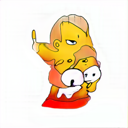
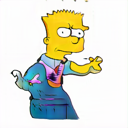
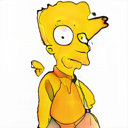
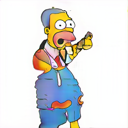
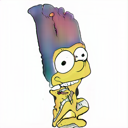
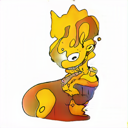
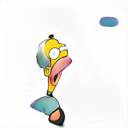
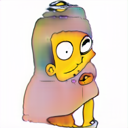
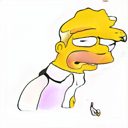
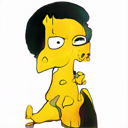
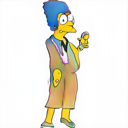
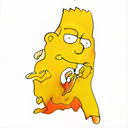
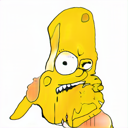
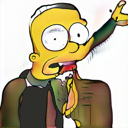
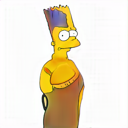
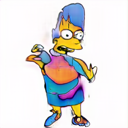
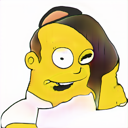
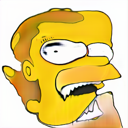
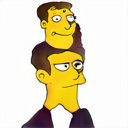
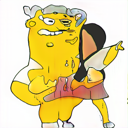
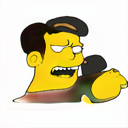
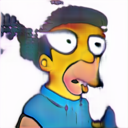
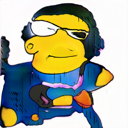
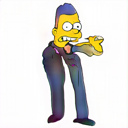
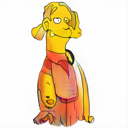
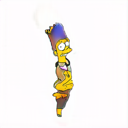
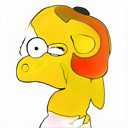
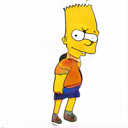
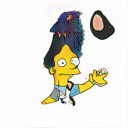
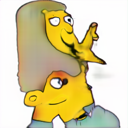
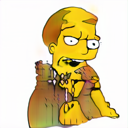
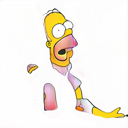
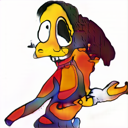
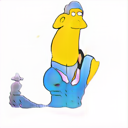
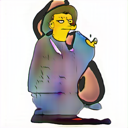
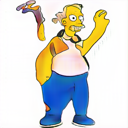
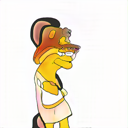
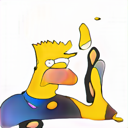
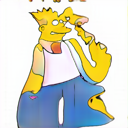
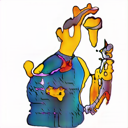
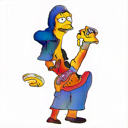
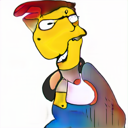
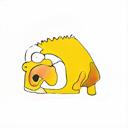
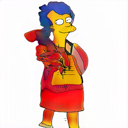
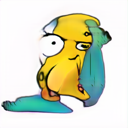
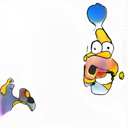
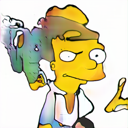
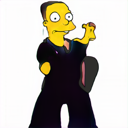
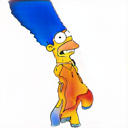
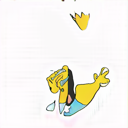
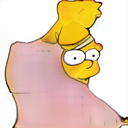
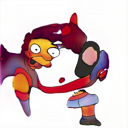
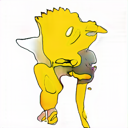
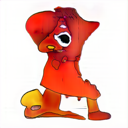
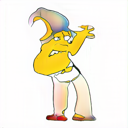
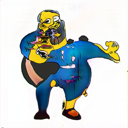
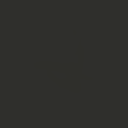
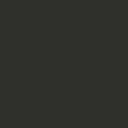
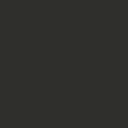
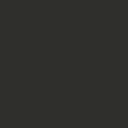
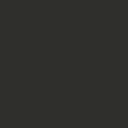
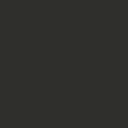
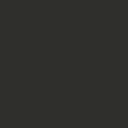
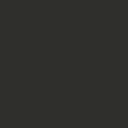
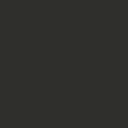
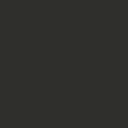
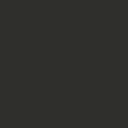
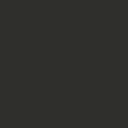
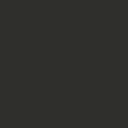
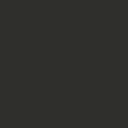
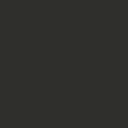
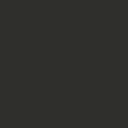
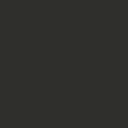
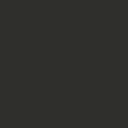
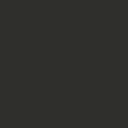
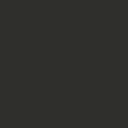
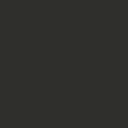
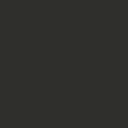
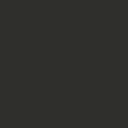
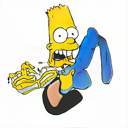
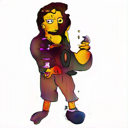
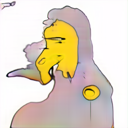
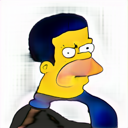
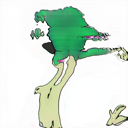
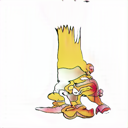
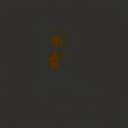
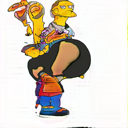
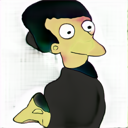
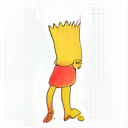
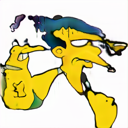
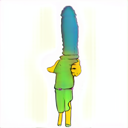
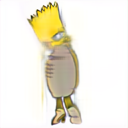
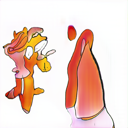
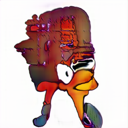
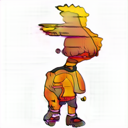
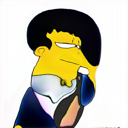
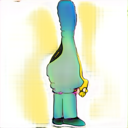
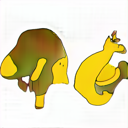
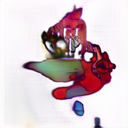
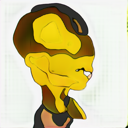

In [14]:
# display_df_images(scored_df[scored_df["score"] < 0.53].sample(50)) #.sort_values("score", ascending=False))
display_df_images(scored_df.sample(100).sort_values("score", ascending=False))